# Periodic boundary conditions

In this tutorial, we compute and relax a skyrmion in an interfacial-DMI (Cnv) material in a part of an infinitely large thin film.

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

We define mesh in cuboid through corner points `p1` and `p2`, and discretisation cell size `cell`.

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xy')

The mesh we defined is:

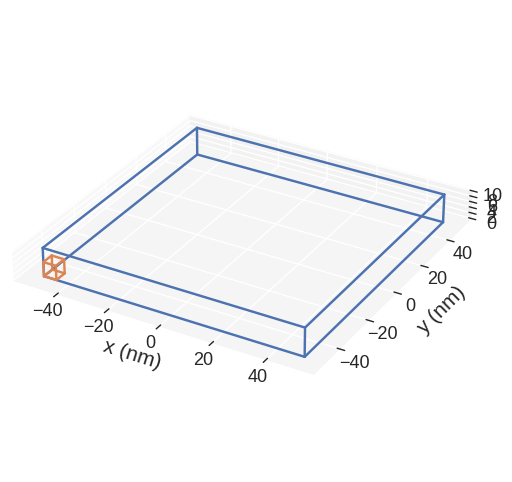

In [5]:
mesh.mpl()

Now, we can define the system object by first setting up the Hamiltonian:

In [6]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z') 
               + mm.UniaxialAnisotropy(K=0.2e6, u=(0, 0, 1)) 
               + mm.Zeeman(H=(0, 0, 1e5)))

system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='Cnv_z') + UniaxialAnisotropy(K=200000.0, u=(0, 0, 1)) + Zeeman(H=(0, 0, 100000.0))

Now, we need to define a function to define the initial magnetisation which is going to relax to skyrmion.

In [7]:
def m_init(pos):
    """Function to set initial magnetisation direction: 
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.
    
    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

system.m = df.Field(mesh, nvdim=3, value=m_init, norm=1.1e6)

The initial magnetsation is:

/home/swapneel/miniconda3/envs/ubermagdev/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/swapneel/miniconda3/envs/ubermagdev/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


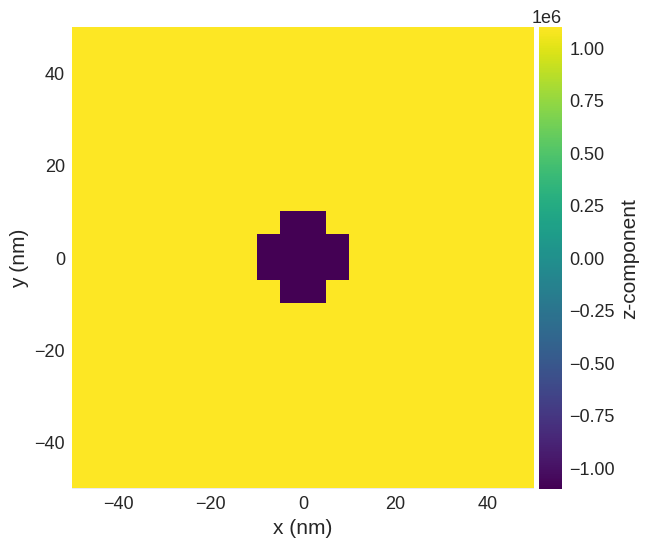

In [8]:
system.m.sel('z').mpl()

Finally we can minimise the energy and plot the magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/08/10 12:19]... (0.3 s)


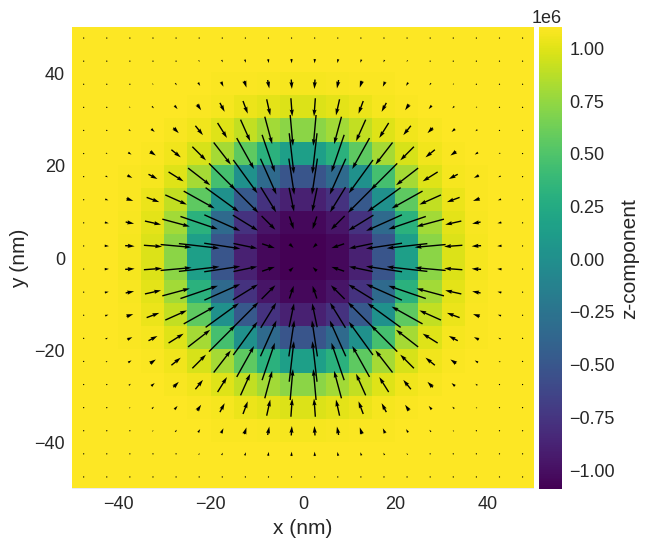

In [9]:
# minimize the energy
md = mc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel('z').mpl()

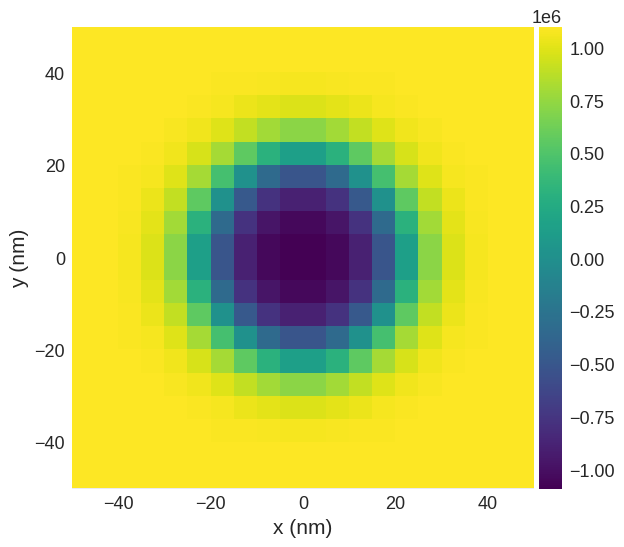

In [10]:
# Plot z-component only:
system.m.z.sel('z').mpl()

Finally we can sample and plot the magnetisation along the line:

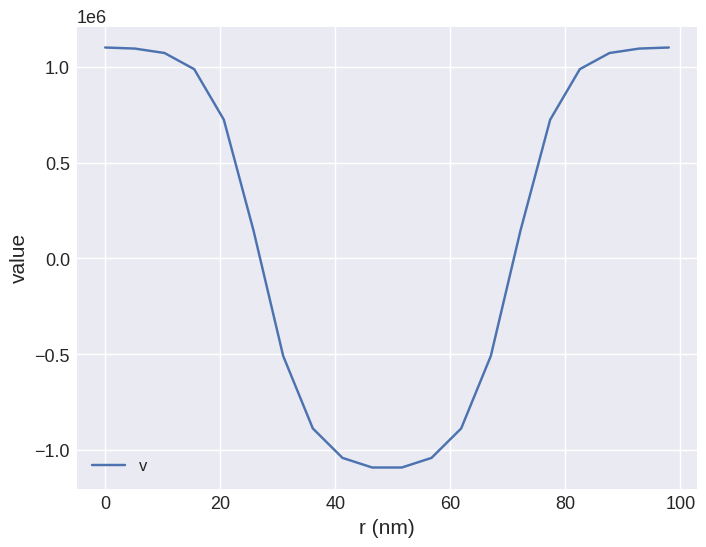

In [11]:
system.m.z.line(p1=(-49e-9, 0, 0), p2=(49e-9, 0, 0), n=20).mpl()

Finally let us compute the skyrmion number

$$S = \frac{1}{4\pi}\int\mathbf{m}\cdot\left(\frac{\partial \mathbf{m}}{\partial x} \times \frac{\partial \mathbf{m}}{\partial y}\right)dxdy$$

In [12]:
m = system.m.orientation.sel('z')

In [13]:
(m.dot(m.diff('x').cross(m.diff('y')))).integrate() / 4 / 3.14

array([-0.92461321])

In [14]:
import math
m = system.m.orientation.sel('z')

1/(4*math.pi) * (m.dot(m.diff('x').cross(m.diff('y')))).integrate()

array([-0.92414447])

In [15]:
import discretisedfield.tools as dft
dft.topological_charge(system.m.sel('z'))

-0.9241444689280445

In [16]:
dft.topological_charge(system.m.sel('z'), method='berg-luescher')

-0.9997455664840109